In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tracemalloc
import tempfile

from src.logs_helper import load_matchs, store_matchs, generate_matchs

In [2]:
df = load_matchs('logs/r6-matches.log')

In [3]:
df.shape

(55833, 4)

In [4]:
df.isnull().sum()

player_id      0
match_id       0
operator_id    0
nb_kills       0
dtype: int64

In [5]:
df.head()

,player_id,match_id,operator_id,nb_kills
0,9e55f54f-a293-4ec5-b7d6-9bab73e2419b,9ba4bf49-8111-413e-bce6-557d2231f7c0,107,3
1,6f560325-2d65-4d21-9f9c-ea8203011c06,c029855e-87ff-49c0-95cd-b7ce323924f8,253,1
2,4377acde-020e-4cf3-a6d7-8a7ab27ac8ea,c51b48a1-b7c7-408e-98fe-219da50333be,233,4
3,45d90033-79a4-4dfe-b1d3-14b84839e0cf,758adcc6-ebe3-416b-b0c7-f0bf0c7bef88,72,4
4,179db9c6-9c0d-4dca-aef9-a86f7b2ee9d2,84ac25ed-d72f-4011-80f6-46f80fde1301,84,3


The logs does not look sorted by match_id, player_id or operator_id.

In [6]:
operators = df.operator_id.unique()
operators.sort()
operators

array([ 14,  24,  30,  46,  64,  72,  73,  84, 100, 107, 109, 112, 130,
       132, 173, 193, 194, 211, 230, 233, 237, 241, 245, 253])

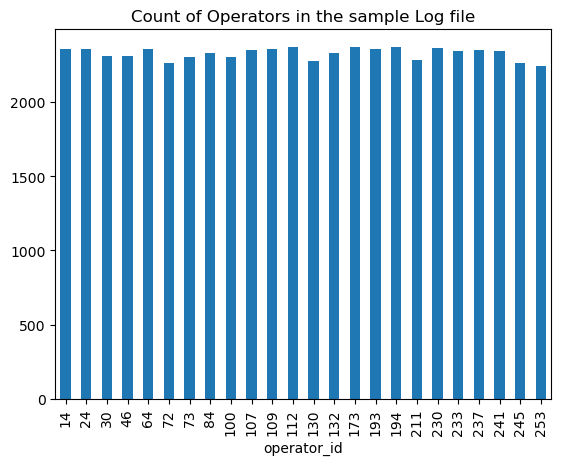

In [7]:
df.operator_id.value_counts().sort_index().plot(kind='bar', title='Count of Operators in the sample Log file')
plt.show()

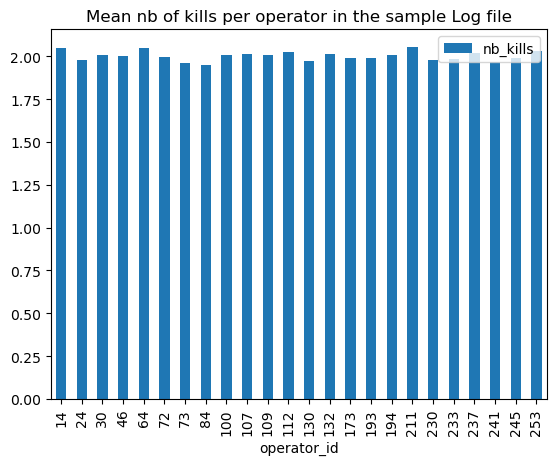

In [8]:
operators_mean_kills = df[['operator_id', 'nb_kills']].groupby('operator_id').mean()
operators_mean_kills.sort_values(by='nb_kills')
operators_mean_kills.plot(kind='bar', title='Mean nb of kills per operator in the sample Log file')
plt.show()

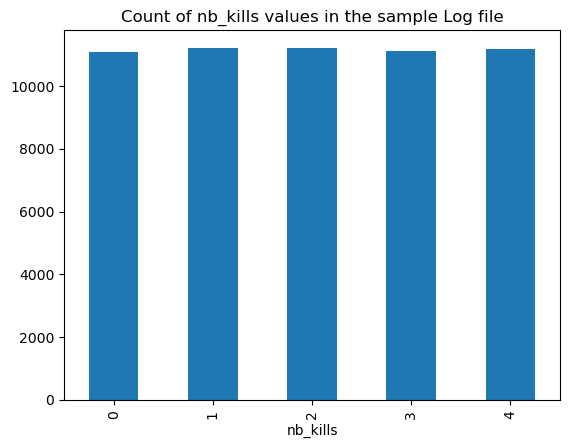

In [9]:
df.nb_kills.value_counts().sort_index().plot(kind='bar', title='Count of nb_kills values in the sample Log file')
plt.show()

In [10]:
len(df.match_id.unique())

1000

In [11]:
len(df['player_id'].unique())

100

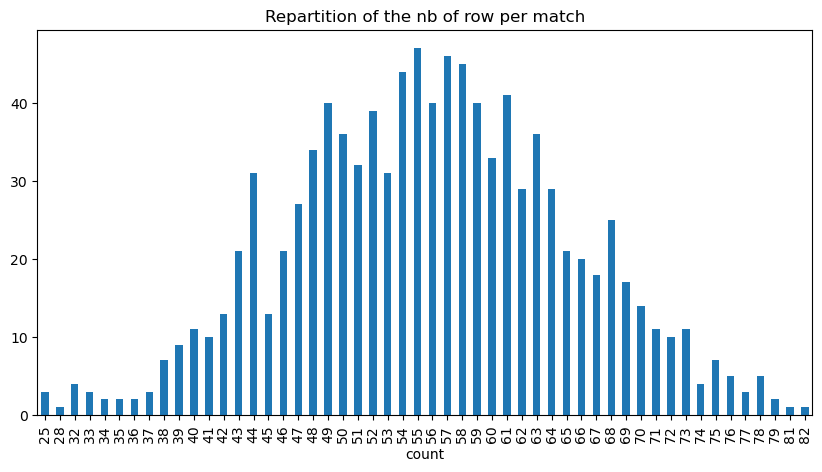

In [12]:
nb_row_per_match = df.match_id.value_counts()

nb_row_per_match_distribution = nb_row_per_match.value_counts().sort_index()

plt.figure(figsize=(10,5))

nb_row_per_match_distribution.plot(kind='bar', title='Repartition of the nb of row per match')
plt.show()

In [13]:
mu = np.mean(nb_row_per_match.values)
std = np.std(nb_row_per_match.values)

print(f'Average nb of row per match: {mu}')
print(f'Std nb of row per match: {std}')

Average nb of row per match: 55.833
Std nb of row per match: 9.328189052543907


In [14]:
df.groupby('match_id')['player_id'].nunique().value_counts()

player_id
10    1000
Name: count, dtype: int64

Its confirmed that all match have 10 players.

Thanks to all these information, I can implement a match generation script.

```python3
>>> %timeit -r 5 -n 3 matchs = generate_matchs(10**4)
... 1.07 s ± 6.82 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)
```

```python3
>>> %time matchs_100k = generate_matchs(10 ** 5)
... CPU times: user 10.7 s, sys: 1.61 s, total: 12.3 s
... Wall time: 12.3 s
```

In [14]:
from pathlib import Path

path_100k = Path('logs/100k_matchs.log')

if not path_100k.exists():

    path_100k.parent.mkdir(parents=True, exist_ok=True)
    file = path_100k.open(mode='w')

    matchs_100k = generate_matchs(10 ** 5)

    store_matchs(file, matchs_100k)

In [15]:
def print_peak_memory_MB(function):
    def sub_func(*args, **kwargs):     
        tracemalloc.start()
        res = function(*args, **kwargs)

        _, peak = tracemalloc.get_traced_memory()
        tracemalloc_memory = tracemalloc.get_tracemalloc_memory()

        tracemalloc.stop()
        function_peak_memory_usage = peak - tracemalloc_memory

        print(f'Peak Memory Usage {function_peak_memory_usage / (1024**2)} MB')
        return res
    return sub_func

In [16]:
@print_peak_memory_MB
def load_100k_matchs(): 
    return load_matchs(path_100k)

matchs_100k = load_100k_matchs()
rows, cols = matchs_100k.shape

print(f'100k matchs represent arround {rows//(10 ** 6)}M and {(rows % (10 ** 6))//(10**5) }00k rows')

Peak Memory Usage 392.8585252761841 MB
100k matchs represent arround 5M and 500k rows


In [17]:
path_1M = Path('logs/1M_matchs.log')
if not path_1M.exists():
    path_1M.parent.mkdir(parents=True, exist_ok=True)

    file = path_1M.open(mode='a')

    for _ in range(10): 
        df = generate_matchs(10 ** 5)
        store_matchs(file, df)

4 min to generate 1M matchs - 4,11 Go 

In [18]:
@print_peak_memory_MB
def get_next_chunk(reader): 
    return reader.get_chunk()

In [19]:
# with load_matchs(path_1M, chunksize=10**6) as reader: # 1M lines
#     chunk = get_next_chunk(reader)

# Peak Memory Usage 71.61651611328125 MB

In [20]:
# with load_matchs(path_1M, chunksize=5*(10**6)) as reader: # 5M lines
#     chunk = get_next_chunk(reader)

# Peak Memory Usage 355.6387710571289 MB

In [21]:
with load_matchs(path_1M, chunksize=10**7) as reader: # 10M lines
    chunk = get_next_chunk(reader)

# Peak Memory Usage 710.5465478897095 MB

Peak Memory Usage 710.5471343994141 MB


In [22]:
# with load_matchs(path_1M, chunksize=2*(10**7)) as reader: # 20M lines
#     chunk = get_next_chunk(reader)

# Peak Memory Usage 1420.363293647766 MB

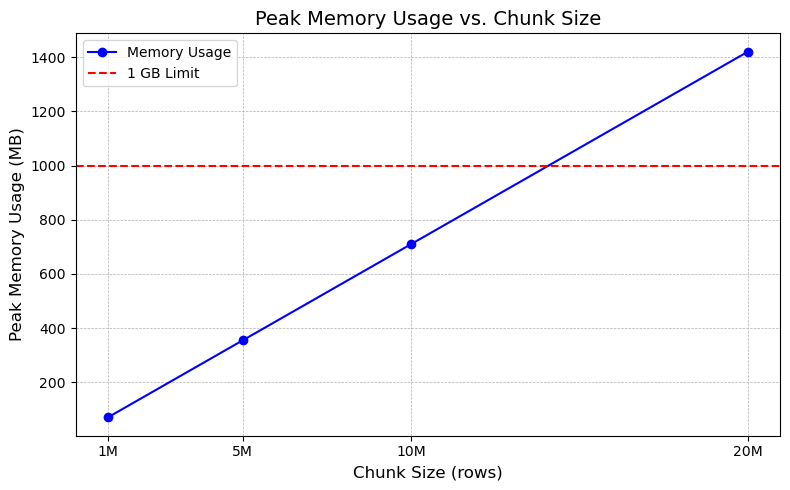

In [23]:
chunk_sizes = [10**6, 5*(10**6), 10**7, 2*(10**7)]
peak_memory_usage_mb = [71, 355, 710, 1420]

# Create the plot
plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(chunk_sizes, peak_memory_usage_mb, marker='o', linestyle='-', color='b', label='Memory Usage')  # Line plot

# Add a horizontal line at 1 GB (1000 MB)
plt.axhline(y=1000, color='r', linestyle='--', label='1 GB Limit')

# Add titles and labels
plt.title('Peak Memory Usage vs. Chunk Size', fontsize=14)
plt.xlabel('Chunk Size (rows)', fontsize=12)
plt.ylabel('Peak Memory Usage (MB)', fontsize=12)

# Customizing the ticks and scaling
plt.xticks(chunk_sizes, ['1M', '5M', '10M', '20M'])  # Format x-axis with readable chunk sizes
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better readability

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

A good tradeoff is a chunksize at 10M lines.

operator_top100_YYYYMMDD.txt (both on the last 7 days.)

operator_id|match_id1:avg_kills1,match_id2:avg_kills2,...,match_id100:avg_kills100 

SELECT 
      operator_id
    , match_id
    , sum(nb_kills)
    , count(*)
FROM matchs 
GROUP BY operator_id, match_id

In [23]:
def count_sum_kills_of_operators_per_match(df): 
    return (
        df.groupby(
            ['operator_id', 'match_id']
        )['nb_kills']
        .aggregate(['sum', 'count'])
        .reset_index()
    )

# works only if you can load the entire df in memory
def top_100_average_kills_per_operator(df: pd.DataFrame): 
    return (
        df.groupby(
            ['operator_id', 'match_id']
        )['nb_kills']
        .mean()
        .reset_index()
        .sort_values(
            by=['operator_id', 'nb_kills'], 
            ascending=[True, False]
        )
        .groupby(
            by='operator_id'
        )
        .head(100)
    )

# a vérifier si c'est vraiment ce qui est demandé dans l'énoncé
def top_10_best_matchs_per_player(df: pd.DataFrame): 
    return (
        df.groupby(
            by=['player_id', 'match_id']
        )['nb_kills']
        .sum()
        .reset_index()
        .sort_values(
            by=['player_id', 'nb_kills'],
            ascending=[True, False]
        )
        .groupby(
            by='match_id'
        ).head(10)
    )

In [24]:
count_sum_kills_of_operators_per_match(df)

,operator_id,match_id,sum,count
0,14,00236da6-e7a0-4d93-83ec-b14969a257ce,6,3
1,14,002d5ee4-fa09-448e-b7d4-228c1ec3d678,8,5
2,14,01e4e65f-b4d4-4561-9fb0-3890246782db,8,3
3,14,0240b2df-ba89-4a1a-b491-a3c34a9e9c86,4,1
4,14,02755770-ee61-4fc7-9832-de7bf64ca252,2,2
...,...,...,...,...
22280,253,fe528b96-a3c8-402b-863c-4d3696bdece6,6,3
22281,253,feb7f3b1-0f0e-43d1-8fb4-c05d9d36374d,10,3
22282,253,fefacf86-8edd-4539-bc87-db5f3c8d86a9,3,3
22283,253,ff2d51de-bb06-469e-b483-3735cfacfdae,7,3


In [28]:
matchs_100k = load_matchs('logs/100k_matchs.log')
print(matchs_100k.shape)
count_sum_kills_of_operators_per_match(matchs_100k)

(5531636, 4)


,operator_id,match_id,sum,count
0,14,000009c4-4f5b-4372-a32e-0baa5a05e089,6,4
1,14,00029586-3111-4e45-8179-872038d2e990,3,2
2,14,0003f77c-733c-455b-b982-116651f0df11,4,1
3,14,00048a98-e9de-4959-af42-c94dc85ae255,4,2
4,14,0005b23c-8cac-4885-b4ef-043f09546367,4,1
...,...,...,...,...
2153600,253,fffcde84-72de-4d63-9605-fb99554a8c83,4,1
2153601,253,fffed33a-9564-4f8a-9e79-535e7b5f03fb,6,4
2153602,253,ffff49cd-629b-4faa-8b98-2eda64e6576b,6,3
2153603,253,ffff6b9b-579a-46f9-b5c4-b20f1cb31ff0,9,3


In [29]:
2153605 / 5531636

0.38932514720780614

In [25]:
22285 / 55833

0.39913671126394784

In [30]:
def store_tempfile(df:pd.DataFrame): 

    with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as temp_file:
        df.to_csv(temp_file, index=False, header=True)
        temp_file_path = temp_file.name

        return temp_file_path

In [34]:
@print_peak_memory_MB
def test_process_file(path, chunksize): 

    tempfile_names = []
    splited_matchs = []

    with load_matchs(path, chunksize=chunksize) as reader: # 10M lines    

        for chunk in reader:
                
            first_match_id = chunk.iloc[0].match_id
            last_match_id = chunk.iloc[-1].match_id

            first_match = chunk[chunk.match_id == first_match_id]
            last_match = chunk[chunk.match_id == last_match_id]

            splited_matchs.append(first_match.copy())
            splited_matchs.append(last_match.copy())
            
            nb_rows_first_match, _ = first_match.shape
            nb_rows_last_match, _ = last_match.shape

            tempfile_name = store_tempfile(
                top_100_average_kills_per_operator(
                    chunk.iloc[nb_rows_first_match: chunksize - nb_rows_last_match]
                )
            )
            tempfile_names.append(tempfile_name)
        
    tempfile_name = store_tempfile(
        top_100_average_kills_per_operator(
            pd.concat(splited_matchs)
        )
    )
    tempfile_names.append(tempfile_name)

    return tempfile_names

In [38]:
chunksize=10**6
tempfile_names = test_process_file(path_100k, chunksize)
tempfile_names

Peak Memory Usage 116.00049304962158 MB


['/tmp/tmpmqsafga0.csv',
 '/tmp/tmptosbtq5n.csv',
 '/tmp/tmptktytpp0.csv',
 '/tmp/tmpp316wqtc.csv',
 '/tmp/tmpl7fxo5eu.csv',
 '/tmp/tmpiya18_21.csv',
 '/tmp/tmpb2jkrlxi.csv']

In [42]:
chunksize=10**7
tempfile_names = test_process_file(path_1M, chunksize)
tempfile_names

Peak Memory Usage 1039.0813903808594 MB


['/tmp/tmpsvl_2kxw.csv',
 '/tmp/tmpzj6vp8yv.csv',
 '/tmp/tmp2rxlnbn6.csv',
 '/tmp/tmpq0be61py.csv',
 '/tmp/tmpfy_lyder.csv',
 '/tmp/tmpmoqqcpjs.csv',
 '/tmp/tmpa8yjw8gd.csv']

In [43]:
concat_temp_df = pd.concat([
    pd.read_csv(tempfile_name) for tempfile_name in tempfile_names
])
concat_temp_df.shape

(14557, 3)

In [44]:
concat_temp_df.head()

,operator_id,match_id,nb_kills
0,14,00092ed5-51a0-41ad-8136-551bd4ed0541,4.0
1,14,0013ed91-d8bb-493a-a5c8-ef09247436d4,4.0
2,14,00203f53-d50b-4a71-8bf8-08b8da45d715,4.0
3,14,0022bcf8-5290-4bee-be95-09f7d912b486,4.0
4,14,00270484-f0a4-4539-b97b-6c1ab633e9af,4.0


In [49]:
top_100 = top_100_average_kills_per_operator(concat_temp_df)

In [50]:
top_100[top_100.nb_kills < 4]

,operator_id,match_id,nb_kills


In [29]:
@print_peak_memory_MB
def compute_metrics(path: str): 
    df = pd.read_csv(path, header=None, names=['player_id', 'match_id', 'operator_id', 'nb_kills'])

    top_avg_kills = top_100_average_kills_per_operator(df)
    # top_best_matchs = top_10_best_matchs_per_player(df)

    return top_avg_kills

top_avg_kills = compute_metrics('logs/100k_matchs.log')

Peak Memory Usage 523.5749797821045 MB


100k matchs seems managable under 1Go of RAM ~ 530 MB RAM

In [23]:
chunksize = 10 ** 5

chunked_df = pd.read_csv('logs/test.log', header=None, names=['player_id', 'match_id', 'operator_id', 'nb_kills'], chunksize=chunksize)

In [24]:
type(chunked_df)

pandas.io.parsers.readers.TextFileReader

In [25]:
chunk = chunked_df.get_chunk()

In [26]:
type(chunk)

pandas.core.frame.DataFrame

In [28]:
temp_file_path = store_tempfile(top_100_average_kills_per_operator(chunk))

In [29]:
pd.read_csv(temp_file_path)

,operator_id,match_id,nb_kills
0,14,0240b2df-ba89-4a1a-b491-a3c34a9e9c86,4.0
1,14,034e52a5-243e-4174-8142-488a47946814,4.0
2,14,055b422d-f92e-4ea3-a159-4d7589ae9cea,4.0
3,14,0644773a-b238-49ea-800c-2f8460cb09ce,4.0
4,14,07d730b7-bed7-438a-967d-04b568334b05,4.0
...,...,...,...
2395,253,cbe05160-7e05-4922-aa0e-74d1b0b0b7ca,4.0
2396,253,cf15539c-999a-4a72-8534-3b2397a9d4c2,4.0
2397,253,d1a65a56-e25e-4c29-a2cf-b274174efbf2,4.0
2398,253,d3a823d6-ae68-4d56-87e0-0d12bb1e8d67,4.0
